# Calculate Time Averages from Time Series Data

Author: [Tom Vo](https://github.com/tomvothecoder/) & [Jiwoo Lee](https://github.com/lee1043/)

Updated: 11/07/24 [xcdat v0.7.3]

Related APIs:

- [xarray.Dataset.temporal.average()](../generated/xarray.Dataset.temporal.average.rst)
- [xarray.Dataset.temporal.group_average()](../generated/xarray.Dataset.temporal.group_average.rst)


## Overview

Suppose we have air temperature data (`air`) with monthly, daily, and 3hr frequencies.

We want to calculate averages using these files with the time dimension removed (a single time snapshot), and averages by time group (yearly, seasonal, and daily).

The data used in this example can be found in the [xarray-data repository](https://github.com/pydata/xarray-data).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook_0.7.3 -c conda-forge xcdat=0.7.3 xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter pooch
```

Then install the kernel from the `xcdat_notebook_0.7.3` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook_0.7.3`):

```bash
python -m ipykernel install --user --name xcdat_notebook_0.7.3 --display-name xcdat_notebook_0.7.3
```

Then to select the kernel `xcdat_notebook_0.7.3` in Jupyter to use this kernel.


In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import xcdat as xc


## 1. Calculate averages with the time dimension removed (single snapshot)

Related API: [xarray.Dataset.temporal.average()](../generated/xarray.Dataset.temporal.average.rst)

Helpful knowledge:

- The frequency for the time interval is inferred before calculating weights.

  - The frequency is inferred by calculating the minimum delta between time coordinates and using the conditional logic below. This frequency is used to calculate weights.

- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data are excluded when averages are calculated. This is the same as giving them a weight of 0.


### Open the `Dataset`

In this example, we will be calculating the time weighted averages with the time dimension removed (single snapshot) for 6-hourly air temperature data (`"air"`)


In [2]:
ds = xc.tutorial.open_dataset("air_temperature", use_cftime=True)

# Unit adjust (-273.15, K to C)
ds["air"] = ds.air - 273.15

ds

<xarray.Dataset> Size: 31MB
Dimensions:    (lat: 25, time: 2920, lon: 53, bnds: 2)
Coordinates:
  * lat        (lat) float32 100B 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon        (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time       (time) object 23kB 2013-01-01 00:00:00 ... 2014-12-31 18:00:00
Dimensions without coordinates: bnds
Data variables:
    air        (time, lat, lon) float64 31MB -31.95 -30.65 ... 23.04 22.54
    lon_bnds   (lon, bnds) float32 424B 198.8 201.2 201.2 ... 328.8 328.8 331.2
    lat_bnds   (lat, bnds) float32 200B 76.25 73.75 73.75 ... 16.25 16.25 13.75
    time_bnds  (time, bnds) object 47kB 2013-01-01 00:00:00 ... 2015-01-01 00...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
ds_avg = ds.temporal.average("air", weighted=True)

In [4]:
ds_avg.air

<xarray.DataArray 'air' (lat: 25, lon: 53)> Size: 11kB
array([[-12.77355822, -12.96694863, -13.26337329, ..., -22.33409932,
        -21.21188356, -19.71195205],
       [-10.41560616, -10.35602397, -10.40066096, ..., -23.39409589,
        -21.56424315, -18.79073973],
       [ -8.3812363 ,  -8.82269178,  -9.08830479, ..., -22.54210959,
        -19.56648973, -15.43440068],
       ...,
       [ 24.49986301,  23.80333219,  23.47931507, ...,  23.66092466,
         23.13796233,  22.66645548],
       [ 24.97920205,  24.78700685,  24.32039384, ...,  23.70954795,
         23.6270274 ,  23.29383562],
       [ 25.21615068,  25.23573973,  24.96414384, ...,  24.18820548,
         24.13144521,  24.15510274]])
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Attributes:
    operation:  temporal_avg
    mode:       average
    freq:       hour
    weighted:   True

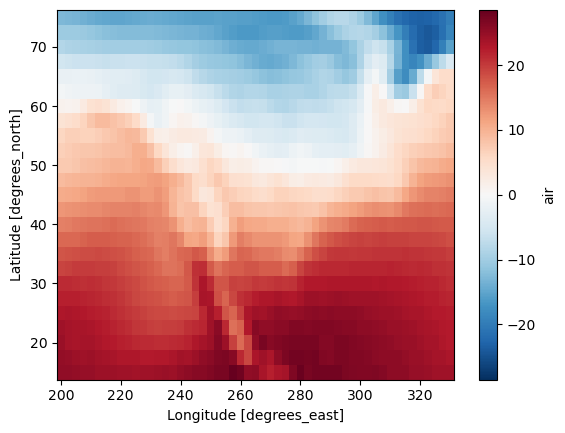

In [5]:
ds_avg.air.plot(label="weighted")

## 2. Calculate grouped averages

Related API: [xarray.Dataset.temporal.group_average()](../generated/xarray.Dataset.temporal.group_average.rst)

Helpful knowledge:

- Each specified frequency has predefined groups for grouping time coordinates.

  - The table below maps type of averages with its API frequency and grouping convention.

    | Type of Averages | API Frequency                                                            | Group By               |
    | ---------------- | ------------------------------------------------------------------------ | ---------------------- |
    | Yearly           | `freq=“year”`                                                            | year                   |
    | Monthly          | `freq=“month”`                                                           | year, month            |
    | Seasonal         | `freq=“season”`                                                          | year, season           |
    | Custom seasonal  | `freq="season"` and </br> `season_config={"custom_seasons": <2D ARRAY>}` | year, season           |
    | Daily            | `freq=“day”`                                                             | year, month, day       |
    | Hourly           | `freq=“hour”`                                                            | year, month, day, hour |

  - The grouping conventions are based on [CDAT/cdutil](https://github.com/CDAT/cdutil/blob/b823b69db46bb76536db7d435e72075fc3975c65/cdutil/times.py#L1620-L1640), except for daily and hourly means which aren't implemented in CDAT/cdutil.

- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data are excluded when averages are calculated. This is the same as giving them a weight of 0.


### Open the `Dataset`

In this example, we will be calculating the weighted grouped time averages for `air` data.


In [6]:
ds = xc.tutorial.open_dataset("air_temperature", use_cftime=True)

# Unit adjust (-273.15, K to C)
ds["air"] = ds.air - 273.15

ds

<xarray.Dataset> Size: 31MB
Dimensions:    (lat: 25, time: 2920, lon: 53, bnds: 2)
Coordinates:
  * lat        (lat) float32 100B 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon        (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time       (time) object 23kB 2013-01-01 00:00:00 ... 2014-12-31 18:00:00
Dimensions without coordinates: bnds
Data variables:
    air        (time, lat, lon) float64 31MB -31.95 -30.65 ... 23.04 22.54
    lon_bnds   (lon, bnds) float32 424B 198.8 201.2 201.2 ... 328.8 328.8 331.2
    lat_bnds   (lat, bnds) float32 200B 76.25 73.75 73.75 ... 16.25 16.25 13.75
    time_bnds  (time, bnds) object 47kB 2013-01-01 00:00:00 ... 2015-01-01 00...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### Yearly Averages

**Group time coordinates by year**


In [7]:
ds_yearly = ds.temporal.group_average("air", freq="year", weighted=True)

In [8]:
ds_yearly.air

<xarray.DataArray 'air' (time: 2, lat: 25, lon: 53)> Size: 21kB
array([[[-13.70783562, -13.86459589, -14.15039041, ..., -22.78481507,
         -21.60773288, -20.08236986],
        [-11.13442466, -11.05367808, -11.11855479, ..., -23.82136986,
         -22.01928082, -19.28924658],
        [ -8.83209589,  -9.28934247,  -9.61319863, ..., -23.25331507,
         -20.34797945, -16.27200685],
        ...,
        [ 24.33323973,  23.56957534,  23.15760274, ...,  23.84621918,
          23.34989041,  22.90093836],
        [ 24.71765753,  24.47973288,  23.99550685, ...,  23.96486301,
          23.88226712,  23.57558219],
        [ 24.94203425,  24.93717808,  24.67607534, ...,  24.47040411,
          24.40113699,  24.42145205]],

       [[-11.83928082, -12.06930137, -12.37635616, ..., -21.88338356,
         -20.81603425, -19.34153425],
        [ -9.69678767,  -9.65836986,  -9.68276712, ..., -22.96682192,
         -21.10920548, -18.29223288],
        [ -7.93037671,  -8.3560411 ,  -8.56341096, ..., -21.83090411,
         -18.785     , -14.59679452],
        ...,
        [ 24.6664863 ,  24.03708904,  23.8010274 , ...,  23.47563014,
          22.92603425,  22.4319726 ],
        [ 25.24074658,  25.09428082,  24.64528082, ...,  23.45423288,
          23.37178767,  23.01208904],
        [ 25.49026712,  25.53430137,  25.25221233, ...,  23.90600685,
          23.86175342,  23.88875342]]])
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) object 16B 2013-01-01 00:00:00 2014-01-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       group_average
    freq:       year
    weighted:   True

### Seasonal Averages

**Group time coordinates by year and season**


In [9]:
ds_season = ds.temporal.group_average("air", freq="season", weighted=True)

In [10]:
ds_season.air

<xarray.DataArray 'air' (time: 9, lat: 25, lon: 53)> Size: 95kB
array([[[-30.45474576, -30.36682203, -30.50084746, ..., -31.07915254,
         -30.06944915, -28.82122881],
        [-28.51614407, -28.47813559, -28.70733051, ..., -32.36279661,
         -30.97228814, -28.43313559],
        [-25.16995763, -25.59728814, -26.29101695, ..., -30.48627119,
         -27.90881356, -23.83478814],
        ...,
        [ 22.49648305,  21.70326271,  21.33059322, ...,  21.98830508,
          21.48665254,  20.91936441],
        [ 23.11813559,  22.87080508,  22.33012712, ...,  22.24177966,
          22.01559322,  21.52033898],
        [ 23.63673729,  23.56084746,  23.25      , ...,  22.92516949,
          22.73563559,  22.64847458]],

       [[-15.6326087 , -15.84429348, -16.19054348, ..., -24.78972826,
         -23.77891304, -22.51769022],
        [-14.49692935, -14.45345109, -14.51820652, ..., -25.3298913 ,
         -23.72633152, -21.39619565],
        [-14.0205163 , -14.63826087, -15.10815217, ..., -25.11967391,
         -22.38184783, -18.55915761],
...
        [ 26.01706044,  25.27870879,  24.99217033, ...,  25.69024725,
          25.31126374,  24.87184066],
        [ 26.52486264,  26.35104396,  25.80881868, ...,  25.68881868,
          25.7889011 ,  25.55848901],
        [ 26.51387363,  26.54862637,  26.21848901, ...,  26.18178571,
          26.18318681,  26.29879121]],

       [[-26.34846774, -26.2608871 , -26.3808871 , ..., -33.07903226,
         -32.06798387, -30.86830645],
        [-25.42      , -24.84927419, -24.40548387, ..., -34.53137097,
         -32.82782258, -30.17967742],
        [-23.18104839, -23.56475806, -23.57475806, ..., -35.44693548,
         -31.91258065, -26.92330645],
        ...,
        [ 23.29919355,  22.54145161,  22.6083871 , ...,  23.37830645,
          23.0675    ,  22.66298387],
        [ 24.2958871 ,  24.28612903,  24.03177419, ...,  23.80258065,
          23.90830645,  23.57903226],
        [ 24.89733871,  25.07612903,  24.90967742, ...,  24.54758065,
          24.57322581,  24.56040323]]])
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) object 72B 2013-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    operation:            temporal_avg
    mode:                 group_average
    freq:                 season
    weighted:             True
    dec_mode:             DJF
    drop_incomplete_djf:  False

**Notice that the season of each time coordinate is represented by its middle month.**

- "DJF" is represented by month 1 ("J"/January)
- "MAM" is represented by month 4 ("A"/April)
- "JJA" is represented by month 7 ("J"/July)
- "SON" is represented by month 10 ("O"/October).

This is implementation design was used because `datetime` objects do not distinguish seasons, so the middle month is used instead.


In [11]:
ds_season.time

<xarray.DataArray 'time' (time: 9)> Size: 72B
array([cftime.DatetimeGregorian(2013, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2013, 4, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2013, 7, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2013, 10, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2014, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2014, 4, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2014, 7, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2014, 10, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2015, 1, 1, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 72B 2013-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    standard_name:  time
    long_name:      Time
    bounds:         time_bnds

In [12]:
ds.air.lat

<xarray.DataArray 'lat' (lat: 25)> Size: 100B
array([75. , 72.5, 70. , 67.5, 65. , 62.5, 60. , 57.5, 55. , 52.5, 50. , 47.5,
       45. , 42.5, 40. , 37.5, 35. , 32.5, 30. , 27.5, 25. , 22.5, 20. , 17.5,
       15. ], dtype=float32)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y
    bounds:         lat_bnds

### Visualize averages derived from monthly data on a specific point


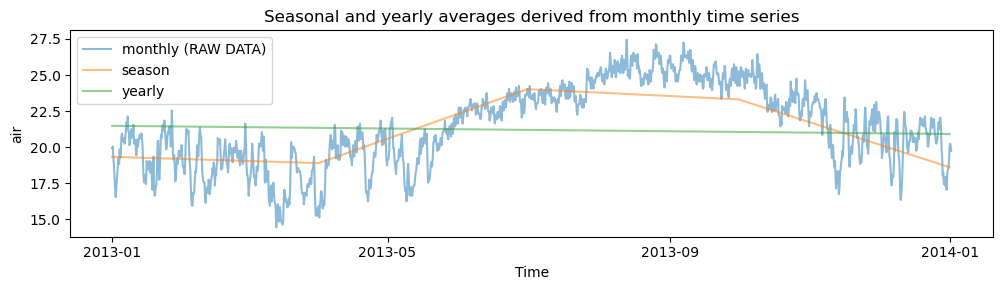

In [13]:
plt.figure(figsize=(10, 3))
ax = plt.subplot()

subset_kwargs = {"lat": 30, "lon": 200, "time": slice("2013-01-01", "2014-01-01")}

ds_air_sub = ds.air.sel(**subset_kwargs).load()
ds_air_sub.plot(ax=ax, label="monthly (RAW DATA)", alpha=0.5)

ds_season_sub = ds_season.air.sel(**subset_kwargs).load()
ds_season_sub.plot(ax=ax, label="season", alpha=0.5)

ds_yearly_sub = ds_yearly.air.sel(**subset_kwargs).load()
ds_yearly_sub.plot(ax=ax, label="yearly", alpha=0.5)

plt.title("Seasonal and yearly averages derived from monthly time series")

plt.legend()
plt.tight_layout()

### Monthly Averages

**Group time coordinates by year and month**


In [14]:
ds_monthly_avg = ds.temporal.group_average("air", freq="month", weighted=True)

In [15]:
ds_monthly_avg.air

<xarray.DataArray 'air' (time: 24, lat: 25, lon: 53)> Size: 254kB
array([[[-28.68322581, -28.48645161, -28.47975806, ..., -30.65854839,
         -29.74362903, -28.47419355],
        [-26.07677419, -26.1275    , -26.4225    , ..., -32.56790323,
         -31.10516129, -28.44282258],
        [-22.77056452, -23.31516129, -24.0425    , ..., -31.16564516,
         -28.38290323, -24.14491935],
        ...,
        [ 22.68814516,  22.00096774,  21.77314516, ...,  22.2183871 ,
          21.73451613,  21.1183871 ],
        [ 23.31951613,  23.16701613,  22.69822581, ...,  22.43774194,
          22.19072581,  21.71556452],
        [ 23.90346774,  23.89201613,  23.58532258, ...,  23.15459677,
          22.94741935,  22.8891129 ]],

       [[-32.41607143, -32.44866071, -32.73848214, ..., -31.54482143,
         -30.43017857, -29.20544643],
        [-31.216875  , -31.080625  , -31.23696429, ..., -32.13571429,
         -30.82517857, -28.42241071],
        [-27.82642857, -28.12392857, -28.78044643, ..., -29.73410714,
         -27.38392857, -23.49142857],
...
        [ 24.89908333,  24.20008333,  24.072     , ...,  24.86183333,
          24.51025   ,  23.99566667],
        [ 25.815     ,  25.66191667,  25.12158333, ...,  24.95408333,
          25.07108333,  24.73558333],
        [ 26.02341667,  26.06766667,  25.74575   , ...,  25.56633333,
          25.59183333,  25.63025   ]],

       [[-26.34846774, -26.2608871 , -26.3808871 , ..., -33.07903226,
         -32.06798387, -30.86830645],
        [-25.42      , -24.84927419, -24.40548387, ..., -34.53137097,
         -32.82782258, -30.17967742],
        [-23.18104839, -23.56475806, -23.57475806, ..., -35.44693548,
         -31.91258065, -26.92330645],
        ...,
        [ 23.29919355,  22.54145161,  22.6083871 , ...,  23.37830645,
          23.0675    ,  22.66298387],
        [ 24.2958871 ,  24.28612903,  24.03177419, ...,  23.80258065,
          23.90830645,  23.57903226],
        [ 24.89733871,  25.07612903,  24.90967742, ...,  24.54758065,
          24.57322581,  24.56040323]]])
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) object 192B 2013-01-01 00:00:00 ... 2014-12-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       group_average
    freq:       month
    weighted:   True

### Daily Averages

**Group time coordinates by year, month, and day**


In [16]:
ds_day_avg = ds.temporal.group_average("air", freq="day", weighted=True)

In [17]:
ds_day_avg.air

<xarray.DataArray 'air' (time: 730, lat: 25, lon: 53)> Size: 8MB
array([[[-31.2775, -30.85  , -30.475 , ..., -39.7775, -37.975 ,
         -35.475 ],
        [-28.575 , -28.5775, -28.875 , ..., -41.9025, -40.325 ,
         -36.85  ],
        [-19.15  , -19.9275, -21.3275, ..., -41.675 , -39.455 ,
         -34.525 ],
        ...,
        [ 23.15  ,  22.825 ,  22.85  , ...,  22.7475,  22.17  ,
          21.795 ],
        [ 23.175 ,  23.575 ,  23.5925, ...,  23.0225,  22.85  ,
          22.3975],
        [ 23.47  ,  23.845 ,  23.95  , ...,  23.8725,  23.8975,
          23.8225]],

       [[-29.55  , -29.65  , -29.85  , ..., -34.1775, -32.3525,
         -30.0775],
        [-25.3275, -25.95  , -26.9275, ..., -37.225 , -36.5525,
         -34.55  ],
        [-19.6275, -21.0775, -22.8525, ..., -35.4525, -34.2775,
         -31.25  ],
...
        [ 23.215 ,  22.265 ,  22.015 , ...,  23.74  ,  23.195 ,
          22.195 ],
        [ 24.3675,  24.515 ,  23.895 , ...,  23.415 ,  22.995 ,
          22.27  ],
        [ 25.4175,  25.5925,  25.1925, ...,  23.6425,  23.19  ,
          22.72  ]],

       [[-28.935 , -29.535 , -30.385 , ..., -29.41  , -28.96  ,
         -28.46  ],
        [-23.835 , -24.06  , -24.56  , ..., -32.585 , -31.635 ,
         -30.035 ],
        [-10.21  , -10.785 , -11.435 , ..., -33.685 , -31.035 ,
         -27.135 ],
        ...,
        [ 21.69  ,  21.99  ,  23.49  , ...,  22.265 ,  22.015 ,
          21.415 ],
        [ 23.39  ,  24.44  ,  24.94  , ...,  22.415 ,  22.315 ,
          21.64  ],
        [ 24.84  ,  25.59  ,  25.54  , ...,  23.065 ,  22.715 ,
          22.39  ]]])
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) object 6kB 2013-01-01 00:00:00 ... 2014-12-31 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       group_average
    freq:       day
    weighted:   True

### Visualize averages derived from 6-hourly data on a specific point


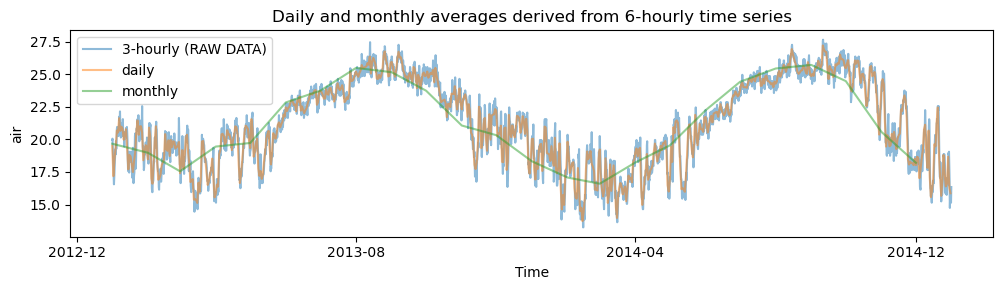

In [18]:
plt.figure(figsize=(10, 3))
ax = plt.subplot()

subset_kwargs = {"lat": 30, "lon": 200}

ds.air.sel(**subset_kwargs).plot(ax=ax, label="3-hourly (RAW DATA)", alpha=0.5)
ds_day_avg.air.sel(**subset_kwargs).plot(ax=ax, label="daily", alpha=0.5)
ds_monthly_avg.air.sel(**subset_kwargs).plot(ax=ax, label="monthly", alpha=0.5)

plt.title("Daily and monthly averages derived from 6-hourly time series")
plt.legend()
plt.tight_layout()